In [1]:
import fastai
from fastai import *
from fastai.vision import *

import pathlib
import os
from PIL import Image
import matplotlib.pyplot as plt

## Creating paths for reading data

In [2]:
pascal_voc = pathlib.PosixPath('./VOCdevkit/VOC2012/')
image_ip = pascal_voc/'JPEGImages'
image_lbl = pascal_voc/'SegmentationClass'

In [3]:
codes = np.array(["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"])

We will use trainval.txt file to get files which will be present in our train+validation set. Using this .txt files we will keep only those files in JPEGImages folder which are present in this .txt file.

In [4]:
files_to_keep = pathlib.PosixPath('./VOCdevkit/VOC2012/ImageSets/Segmentation/')
keep_train_val = files_to_keep/'val.txt'
keep_train_val

PosixPath('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')

For deleting the files from JPEGImages folder run the below script
This approach is usefull when we want to make equivalent input and output image folders via deletion so as to read 
via. SegmentationItemList.from_folder()

In [5]:
# list_of_files = os.listdir(image_ip)    #total no. of images

# fnames = []     #images to be included
# with open(keep_train_val,'r') as f:
#     for name in f:
#         fnames.append(name.strip()+'.jpg')
            
            
# for x in list_of_files:
#     if(x not in fnames):
#         print(x)
# #         os.remove(image_ip/x)

## Reading the data
Let's first create the databunch using datablock APIs. First we will try out with size=128 then we will move to size=224

### Run the cells so as to override SegmentationItemList function

Overriding SegmentationLabelList class with ***open()*** so that it opens ground truth segmentation masks with ***convert_mode='P'***

In [5]:
class SegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): self.classes = ds.classes
    def process(self, ds:ItemList):  ds.classes,ds.c = self.classes,len(self.classes)

In [6]:
class SegmentationLabelList(ImageItemList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def new(self, items, classes=None, **kwargs):
        return self.new(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn,convert_mode='P')   #HERE
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [7]:
class SegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

### Creating a function for mapping label mask to input image

In [8]:
get_y_fn = lambda x: image_lbl/f'{x.stem}.png'

### Creating databunch

In [11]:
data = (SegmentationItemList.from_folder(image_ip)
        .random_split_by_pct()
        .label_from_func(get_y_fn,classes=codes)
        .transform(get_transforms(),size=128,tfm_y=True)
        .databunch(bs=4))
#          .normalize(imagenet_stats))

Run the below command only once

In [11]:
data.classes

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
       'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='<U11')

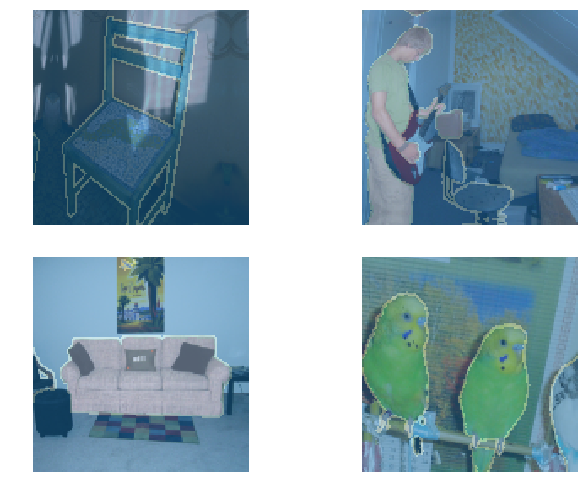

In [17]:
data.show_batch(rows=2,figsize=(10,7))

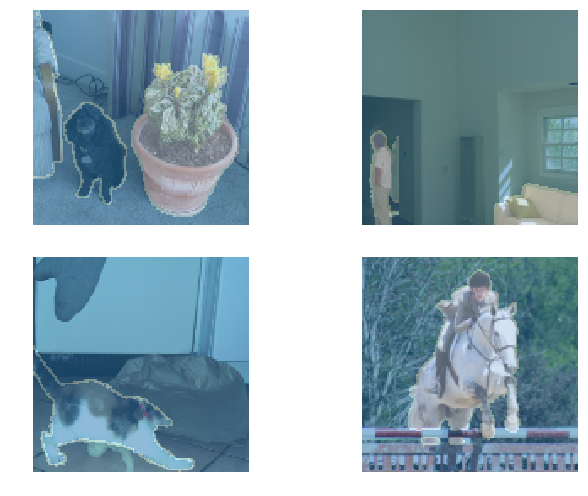

In [18]:
data.show_batch(rows=2,figsize=(10,7),ds_type=DatasetType.Valid)

## Creating model

### Errors encountered while creating learner object

* Use loss function as nn.CrossEntropyLoss() with ignore_index=255 = DONE
* Since the input images are of 3 channels and output images are of 1 channel. Find a way to reduce the no. of channels of y_hat = 1. = DONE
* the above error can also be solved by using n_classes = 1
* for reference = https://forums.fast.ai/t/dynamic-unet/14619/29
* For accuracy metrics check if the segmentation mask contains 255 pixel value or not

In [9]:
def custom_loss(y_hat,y):
    y = y.squeeze(1)
    loss = nn.CrossEntropyLoss(ignore_index=255)
    return loss(y_hat,y)

In [10]:
def custom_acc(input,targs):
    targs = targs.squeeze(dim=1)
    input = input.argmax(dim=1)
    
    return (input.flatten()==targs.flatten()).float().mean()

In [14]:
learn = unet_learner(data,models.resnet34,metrics=custom_acc,loss_func=custom_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


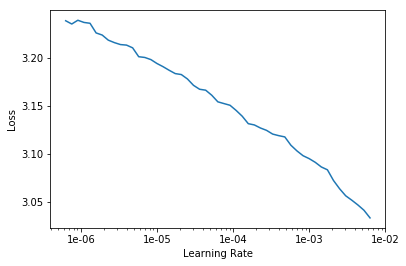

In [14]:
lr_find(learn)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10,slice(1e-3))

epoch,train_loss,valid_loss,custom_acc
1,2.609290,2.909570,0.401458
2,2.219605,2.227480,0.615033
3,1.675648,1.407284,0.692025
4,1.332092,1.158234,0.695405
5,1.143157,0.986615,0.707877
6,1.057864,0.898067,0.720968
7,0.958999,0.822893,0.728127
8,0.907806,0.808271,0.734883
9,0.814608,0.780910,0.737585
10,0.834707,0.774383,0.740105


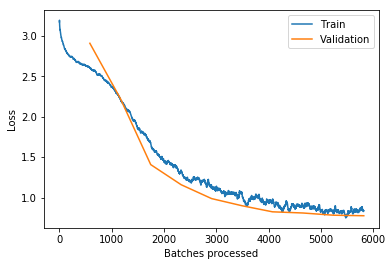

In [16]:
learn.recorder.plot_losses()

## Prediction

In [19]:
img = learn.data.valid_ds[0][0]
learn.predict(img)

(ImageSegment (1, 128, 128), tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]]), tensor([[[ 4.5856,  4.5882,  4.5551,  ...,  4.7410,  4.7440,  4.7500],
          [ 4.5971,  4.6035,  4.5722,  ...,  4.7543,  4.7560,  4.7591],
          [ 4.6035,  4.6097,  4.6014,  ...,  4.7610,  4.7634,  4.7662],
          ...,
          [ 4.7067,  4.7021,  4.6910,  ...,  4.1472,  4.1641,  4.1756],
          [ 4.6691,  4.6659,  4.6589,  ...,  4.1474,  4.1874,  4.2245],
          [ 4.6324,  4.6300,  4.6276,  ...,  4.1404,  4.2055,  4.2660]],
 
         [[-0.8115, -0.8221, -0.8325,  ..., -0.8316, -0.8285, -0.8187],
          [-0.8153, -0.8234, -0.8337,  ..., -0.8309, -0.8276, -0.8180],
          [-0.8186, -0.8266, -0.8312,  ..., -0.8354, -0.8292, -0.8173],
          ...,
          [-0.8371, -0

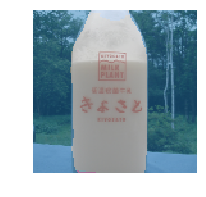

In [20]:
img.show(y=learn.predict(img)[0])

In [21]:
learn.save('stage-1_128')

### Chaging sizes and retraining

Increasing the size of image to 224

In [13]:
data = (SegmentationItemList.from_folder(image_ip)
        .random_split_by_pct()
        .label_from_func(get_y_fn,classes=codes)
        .transform(get_transforms(),size=224,tfm_y=True)
        .databunch(bs=4))

Exporting databunch will allow us to create export.pkl file which will be used to create Empty databunch while in inference mode.

In [14]:
data.export()

In [14]:
learn.load('stage-1_128')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (2331 items)
[ImageSegment (1, 281, 500), ImageSegment (1, 366, 500), ImageSegment (1, 375, 500), ImageSegment (1, 375, 500), ImageSegment (1, 375, 500)]...
Path: VOCdevkit/VOC2012/JPEGImages
x: SegmentationItemList (2331 items)
[Image (3, 281, 500), Image (3, 366, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 375, 500)]...
Path: VOCdevkit/VOC2012/JPEGImages;

Valid: LabelList
y: SegmentationLabelList (582 items)
[ImageSegment (1, 402, 500), ImageSegment (1, 334, 500), ImageSegment (1, 437, 480), ImageSegment (1, 500, 375), ImageSegment (1, 284, 500)]...
Path: VOCdevkit/VOC2012/JPEGImages
x: SegmentationItemList (582 items)
[Image (3, 402, 500), Image (3, 334, 500), Image (3, 437, 480), Image (3, 500, 375), Image (3, 284, 500)]...
Path: VOCdevkit/VOC2012/JPEGImages;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


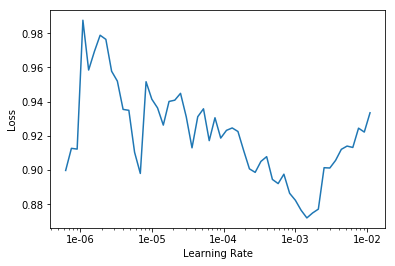

In [15]:
lr_find(learn)
learn.recorder.plot()

In [16]:
#Size of input
learn.data.train_ds[0][0].size

torch.Size([224, 224])

In [17]:
learn.fit(10,slice(1e-4))

epoch,train_loss,valid_loss,custom_acc
1,0.812718,0.698740,0.752013
2,0.898351,0.677790,0.757545
3,0.847385,0.665489,0.759895
4,0.758610,0.651306,0.763683
5,0.764246,0.635971,0.767311
6,0.688265,0.612755,0.771826
7,0.718797,0.593574,0.780536
8,0.688285,0.594990,0.786408
9,0.691262,0.575605,0.790527
10,0.646573,0.578395,0.787478


In [18]:
learn.save('stage-1_224_opt_f',with_opt=False)

In [19]:
img = learn.data.valid_ds[2][0]

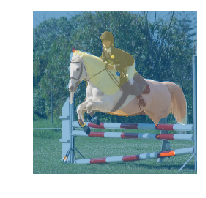

In [20]:
img.show(y=learn.predict(img)[0])

In [20]:
img.size

torch.Size([224, 224])

### Making predictions on different images

Creating an empty inference learner

In [11]:
empty_data = ImageDataBunch.load_empty(image_ip,fname="export.pkl")

Initializing model on empty ImageDataBunch

In [12]:
learn = unet_learner(empty_data,models.resnet34,metrics=custom_acc,loss_func=custom_loss)

In [13]:
learn.load('stage-1_224_opt_f',strict=False)

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (1 items)
[]...
Path: VOCdevkit/VOC2012/JPEGImages
x: SegmentationItemList (1 items)
[]...
Path: VOCdevkit/VOC2012/JPEGImages;

Valid: LabelList
y: SegmentationLabelList (1 items)
[]...
Path: VOCdevkit/VOC2012/JPEGImages
x: SegmentationItemList (1 items)
[]...
Path: VOCdevkit/VOC2012/JPEGImages;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, ke

In [14]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [4, 64, 112, 112]    9408       False     
______________________________________________________________________
BatchNorm2d          [4, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [4, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [4, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [4, 64, 56, 56]      36864      False     
______________________________________________________________________
BatchNorm2d          [4, 64, 56, 56]      128        True      
______________________________________________________________________
ReLU                 [4, 64, 56, 56]      0          False     
______________________________________________________________

In [28]:
img = open_image('person_bicycle.jpg')

In [29]:
img.resize(size=224)
img.data.size()

torch.Size([3, 224, 224])

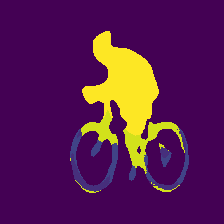

In [30]:
img_pred = learn.predict(img)
img_pred[0]

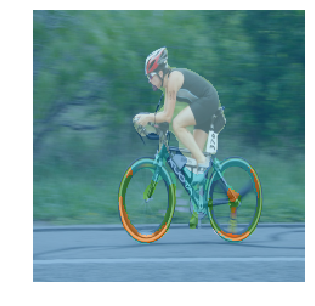

In [31]:
img.show(y=learn.predict(img)[0],figsize=(5,5))

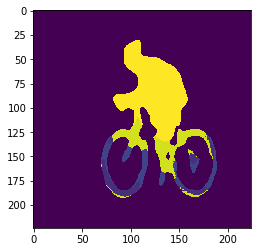

In [32]:
# plt.imshow(img_pred[0].data)
temp = np.array(learn.predict(img)[0].data)
temp = temp.squeeze()
plt.imshow(temp)